In [20]:
import math
from collections import namedtuple
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from copy import deepcopy
from tqdm.notebook import tqdm
import random

from numba import jit, vectorize, float64

In [58]:
with open('./data/tsp_51_1', 'r') as input_data_file:
    input_data = input_data_file.read()
    
lines = input_data.split('\n')

nodeCount = int(lines[0])

points = []
for i in range(1, nodeCount+1):
    line = lines[i]
    parts = line.split()
    # points.append(Point(float(parts[0]), float(parts[1])))
    points.append((float(parts[0]), float(parts[1])))
points = np.array(points)

In [59]:
def length(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


def scan_region_from(current_point, remaining_stops):
    x, y = current_point
    
    if x < y:
        x_min = np.min(remaining_stops[:, 0])
        scan_pointer = np.array([x_min, y])
    else:
        y_min = np.min(remaining_stops[:, 1])
        scan_pointer = np.array([x, y_min])

    return scan_pointer


def add_explored(current_stop, remaining_stops):
    ## Add node as explored
    
    # Find the index where the element matches in the array_of_arrays
    remove_idx = np.where(np.all(remaining_stops == current_stop, axis=1))
    
    # Remove the element using the indices
    remaining_stops = np.delete(remaining_stops, remove_idx, axis=0)
    
    return remaining_stops


def point_in_bbox(point, bbox):
    x, y = point
    x_min, y_min, x_max, y_max = bbox
    
    if x_min <= x <= x_max and y_min <= y <= y_max:
        return True
    else:
        return False


def calculate_travel(exploring_path):
    distances = np.linalg.norm(exploring_path[1:] - exploring_path[:-1], axis=1)
    return np.sum(distances)

In [60]:
@jit(nopython=True)
def length_distance(single_point, all_points):
    return np.sqrt((all_points[:, 0]-single_point[0])**2 + (all_points[:, 1]-single_point[1])**2)

In [61]:
explored_path = [[] for _ in range(len(points))]
explored_indexes = [] #set()
distance_matrix = np.array([0, 0, 0])
node_number = 0
points_count = points.shape[0]
max_size = 0

neighbors_to_account = 50 #points_count//5

with tqdm() as tbar:
    while len(set(explored_indexes)) < points_count:

        explored_indexes = list(set(explored_indexes))
        
        one_point = points[node_number]
        explored_indexes.append(node_number)
    
        neighbor_distances = length_distance(one_point, points)
        neighbor_idx = np.argsort(neighbor_distances)
        parent_idx = np.array([node_number]*points_count)[:, np.newaxis]
        sorted_neighbors = np.hstack((parent_idx, neighbor_idx[:, np.newaxis], neighbor_distances[neighbor_idx][:, np.newaxis]))[:neighbors_to_account]
    
        distance_matrix = np.vstack((distance_matrix, sorted_neighbors))
        
        mask = np.logical_not(np.isin(distance_matrix[:, 1], explored_indexes))
        distance_matrix = distance_matrix[mask]
    
        if not distance_matrix.size:
            neighbors_to_account *= 2
            continue

        distance_matrix = distance_matrix[np.argsort(distance_matrix[:, 2])] ## sort by distance


        if distance_matrix.shape[0] > max_size:
            max_size = distance_matrix.shape[0]
    
        ## Add to graph
        parent_node = int(distance_matrix[0][0])
        neighbor_node = int(distance_matrix[0][1])
        
        explored_path[parent_node].append(neighbor_node)
        explored_path[neighbor_node].append(parent_node)
        
        ## Explore next node
        node_number = neighbor_node
        tbar.update(1)

        # if len(set(explored_indexes)) ==2:
        #     break
print(len(set(explored_indexes)))     

0it [00:00, ?it/s]

51


In [62]:
DISTANCE_MATRIX = np.zeros((nodeCount, nodeCount))
for i in tqdm(range(len(points))):
    DISTANCE_MATRIX[i] = length_distance(points[i], points)

  0%|          | 0/51 [00:00<?, ?it/s]

In [63]:
odd_indexes = []

for idx, connections in enumerate(explored_path):

    if len(connections)%2 == 1:
        odd_indexes.append(idx)

In [13]:
odd_indexes_neighbors = [[] for _ in range(nodeCount)]

for node in odd_indexes:
    mask = np.isin(np.argsort(DISTANCE_MATRIX[node]), odd_indexes)
    odd_indexes_neighbors[node] = np.argsort(DISTANCE_MATRIX[node])[mask][1:3]

In [14]:
for _ in tqdm(range(1000)):
    
    temp = deepcopy(odd_indexes)
    joined_path = deepcopy(explored_path)
    
    net_pair_distance = 0
    
    best_distance = float('inf')
    best_path = []
    
    while len(temp) > 0:
    
        node = temp.pop(0)
        next_node = random.choice(odd_indexes_neighbors[node])
    
        net_pair_distance += DISTANCE_MATRIX[node][next_node]
        
        if next_node not in joined_path[node]:
            joined_path[node].append(next_node)
    
        if next_node in temp:
            temp.remove(next_node)

    if net_pair_distance < best_distance:
        best_distance = net_pair_distance
        best_path = deepcopy(joined_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
best_distance

192.87928484771578

In [16]:
joined_path[14]

[44]

In [65]:
edge_x = []
edge_y = []

for idx, connections in tqdm(enumerate(explored_path)):
    
    x0, y0 = points[idx]
    
    for connect in connections:
        x1, y1 = points[connect]
    
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)


0it [00:00, ?it/s]

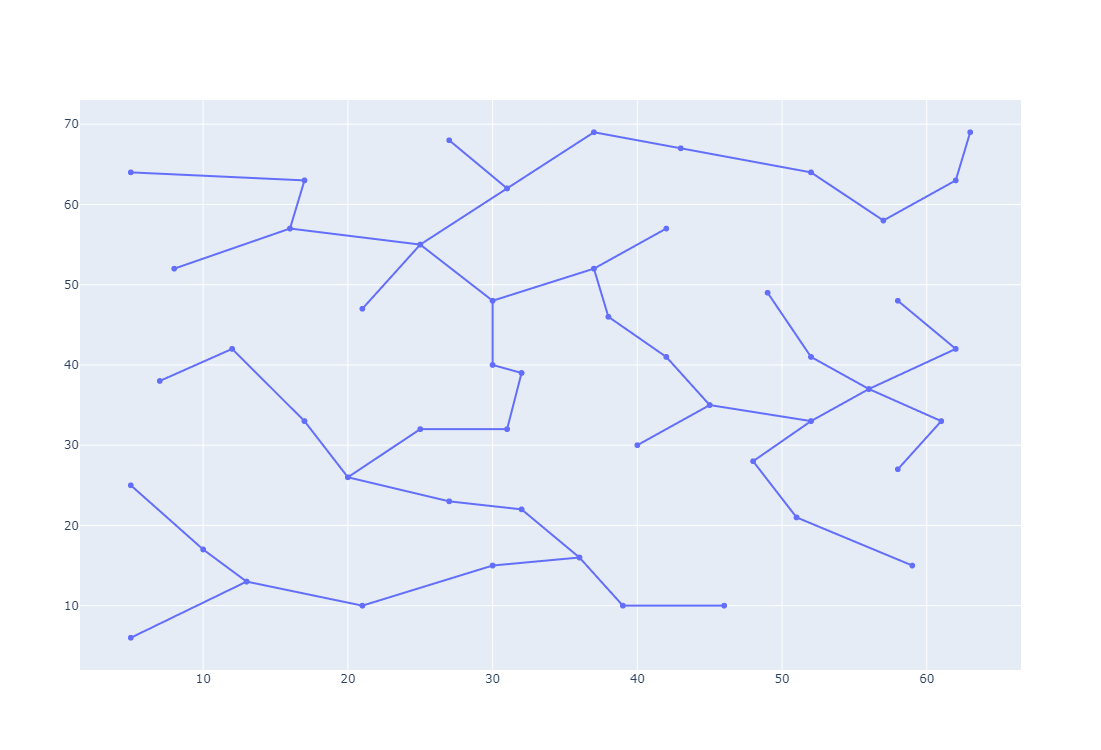

In [66]:


fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(height=750)
fig.show()


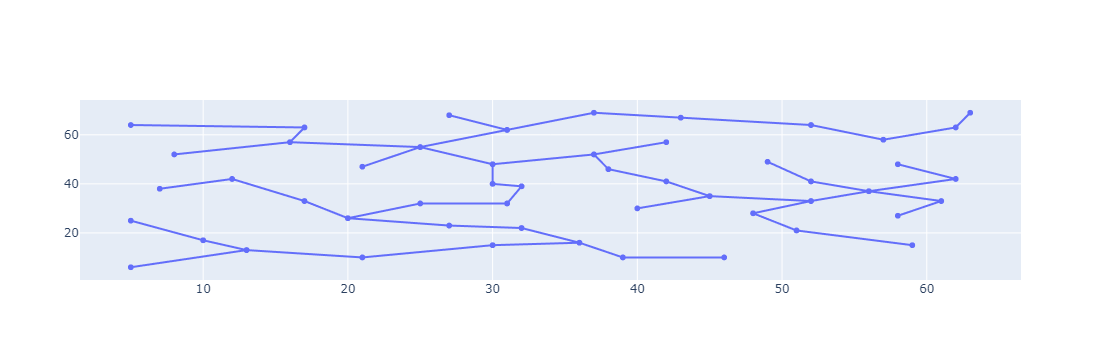

In [23]:


fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(height=750)
fig.show()


In [ ]:
edge_x = []
edge_y = []

for idx in tqdm(list(global_optimal_path) + [list(global_optimal_path)[0]]):
    
    x0, y0 = points[idx]
    
    edge_x.append(x0)
    edge_y.append(y0)

In [ ]:
explored_path

In [ ]:
fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(width=1200, height=1200*layout_ratio)
fig.show()

In [ ]:

x_points = [x for x, y in points]
y_points = [y for x, y in points]
layout_ratio = max(x_points)/max(y_points)

fig = go.Figure(data=go.Scattergl(
    x=x_points,
    y=y_points,
    # mode="markers+lines",
    mode="markers"
))
fig.update_layout(width=1200, height=1200*layout_ratio)
fig.show()

In [7]:

x_points = [x for x, y in exploring_path]
y_points = [y for x, y in exploring_path]
layout_ratio = max(x_points)/max(y_points)

fig = go.Figure(data=go.Scattergl(
    x=x_points,
    y=y_points,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(width=1200, height=1200*layout_ratio)
fig.show()

NameError: name 'exploring_path' is not defined

In [ ]:
## Working MST

# explored_path = [[] for _ in range(len(points))]
# explored_indexes = [] #set()
# distance_matrix = np.array([0, 0, 0])
# node_number = 0
# points_count = points.shape[0]
# max_size = 0

# neighbors_to_account = 50 #points_count//5

# with tqdm() as tbar:
#     while len(set(explored_indexes)) < points_count:

#         explored_indexes = list(set(explored_indexes))
        
#         one_point = points[node_number]
#         explored_indexes.append(node_number)
    
#         neighbor_distances = length_distance(one_point, points)
#         neighbor_idx = np.argsort(neighbor_distances)
#         parent_idx = np.array([node_number]*points_count)[:, np.newaxis]
#         sorted_neighbors = np.hstack((parent_idx, neighbor_idx[:, np.newaxis], neighbor_distances[neighbor_idx][:, np.newaxis]))[:neighbors_to_account]
    
#         distance_matrix = np.vstack((distance_matrix, sorted_neighbors))
        
#         mask = np.logical_not(np.isin(distance_matrix[:, 1], explored_indexes))
#         distance_matrix = distance_matrix[mask]
    
#         if not distance_matrix.size:
#             neighbors_to_account *= 2
#             continue

#         distance_matrix = distance_matrix[np.argsort(distance_matrix[:, 2])] ## sort by distance


#         if distance_matrix.shape[0] > max_size:
#             max_size = distance_matrix.shape[0]
    
#         ## Add to graph
#         parent_node = int(distance_matrix[0][0])
#         neighbor_node = int(distance_matrix[0][1])
        
#         explored_path[parent_node].append(neighbor_node)
#         explored_path[neighbor_node].append(parent_node)
        
#         ## Explore next node
#         node_number = neighbor_node
#         tbar.update(1)

#         # if len(set(explored_indexes)) ==2:
#         #     break
# print(len(set(explored_indexes)))     